# NGDS Wetterdaten - Projekt Wetterstation Bern

Im Projekt geht es um Wetterdaten. Uns wurde die Wetterstation Bern 2021 - 2022 zugeteilt.  Sie beinhaltet folgende Messwerte über ein ganzes Jahr:

|  Header   |        Bedeutung        |  Einheit   |
| :-------: | :---------------------: | :--------: |
|    stn    |      Wetterstation      |     -      |
|   time    |       Zeitstempel       | `datetime` |
| prestah0  |        Luftdruck        |    hPa     |
| tre200h0  |       Temperatur        |     °C     |
| rre150h0  |       Regenmenge        |     mm     |
| su2000h0  |      Sonnenstunden      |     %      |
| time_diff | Stunden seit Messbeginn |     h      |

## Ziel des Projekts:

Das Ziel des Projekts ist es, mithilfe der Numerischen Analyse und Interpretation von Wetterdaten ein umfassendes Verständnis für meteorologische Phänomene zu erlangen. Durch die Extraktion, Verarbeitung und Interpretation von Wetterdaten möchten wir detaillierte Einblicke in Parameter wie Temperatur, Luftdruck, Niederschlagsmenge und Sonnenscheindauer gewinnen. Unsere Analyse zielt darauf ab, Muster, Trends und spezifische Ereignisse in den Daten zu identifizieren, um ein tieferes Verständnis für das Wettergeschehen zu entwickeln und mögliche Auswirkungen auf Umwelt und Gesellschaft zu untersuchen.

## 1. Import der Daten

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import datetime as dt
from datetime import datetime, timedelta
from scipy.integrate import quad

Wie wir wissen, fehlen gewisse Daten in der Datenstruktur. Um die Möglichkeit frei zu behalten, zu einem späteren Zeipunkt fehlende Werte zu ergänzen oder zu filtern haben wir uns für die Funktion `genfromtxt` entschieden. 

In einem nächsten Schritt filtern wir die expliziten Daten der Wetterstation **Bern**. 

In [52]:
# Hier hat man genfromtxt() benutzt, um die Daten aus der CSV-Datei zu laden.
data = np.genfromtxt("Bern21-22.csv", delimiter=';', skip_header=1, dtype=str)
stn, time, luftdruck, temperaturen, regen, sonne, time_diff = data.T

In [53]:
def daten_filtern(datenset): 
    """
    Filtert ein Datensatz-Array auf diejenigen Daten, die mit 'BER' beginnen.

    Parameters
    ----------
    datenset : numpy.ndarray
        Das Eingabe-Array, das gefiltert werden soll.

    Returns
    -------
    numpy.ndarray
        Das gefilterte Array, das nur die Daten mit 'BER' am Anfang der ersten Spalte enthält.
    """
    ber_data = data[np.char.startswith(data[:,0], "BER")]
    return ber_data

In [54]:
def daten_bereinigen(datenset): 
    """
    Bereinigt das Eingabedatenset, indem die ersten beiden Spalten entfernt werden.

    Parameters
    ----------
    datenset : numpy.ndarray
        Das Eingabedatenset.

    Returns
    -------
    numpy.ndarray
        Das bereinigte Datenset ohne die ersten beiden Spalten.
    """
    bereinigte_daten = np.delete(datenset, [0, 1], axis=1)
    return bereinigte_daten

clean_data = daten_bereinigen(daten_filtern(data))

In [55]:
# shape und len() der Arrays ausgeben
print(f" Der ursprüngliche Datensatz beträgt {data.shape}, {clean_data.shape}")
print(len(data),len(clean_data))

# Die ersten 5 Zeilen ausgeben
print(clean_data[:5])

 Der ursprüngliche Datensatz beträgt (52324, 7), (7464, 5)
52324 7464
[['941.4' '7.2' '0.0' '0.0' '0.0']
 ['941.4' '7.5' '0.0' '0.0' '1.0']
 ['941.1' '8.3' '0.7' '0.0' '2.0']
 ['941.3' '9.6' '1.0' '0.0' '4.0']
 ['942.2' '9.6' '1.7' '0.0' '6.0']]


Eine Reduktion von **52'324** auf **7464** Daten kann durch diesen Prozess beobachtet werden. Trotz der gefilterten Daten bleibt die Zeilenanzahl enthalten. 

Dieser Verlust von Daten deutet auf eine erhebliche Bereinigung hin, bei der Datenpunkte ausgeschlossen wurden, die nicht den erforderlichen Kriterien entsprachen.

Wir möchten nun in Erfahrung bringen wie viele Daten fehlen, damit wir uns ein Bild machen und in einem zweiten Schritt entscheiden können, wie wir dieses Problem am effizientesten beheben und bereinigen sollen.

In [56]:
datensätze = 365 * 24 #365 Tage * 24 Stunden
unsere_datensätze = len(clean_data)
print(f"Es fehlen insgesamt {datensätze - unsere_datensätze} Datensätze.")

Es fehlen insgesamt 1296 Datensätze.


Es wurden 1.296 fehlende Datensätze erkannt. Dies kann  auf Lücken in der ursprünglichen Datensammlung hinweisen.

Für die weitere Verarbeitung und Analyse der Daten haben wir die Funktion "daten_aufteilen" entwickelt. Diese Funktion nimmt als Input eine Datenmatrix, in Form eines Numpy-Arrays, und teilt diese in einzelne Arrays auf, die jeweils unterschiedliche klimatische Variablen repräsentieren.

In [57]:
def daten_aufteilen(daten):
    """
    Teilt eine gegebene Datenmatrix in einzelne Arrays auf, welche die verschiedenen Klimadaten enthalten.

    Parameter
    ----------
    daten : numpy.ndarray
        Eine Matrix mit den Klimadaten.
        
    Rückgabe
    -------
    tuple of numpy.ndarray
        Eine Liste mit einzelnen Arrays, welche die verschiedenen Klimadaten enthalten.
    """
    luftdruck = daten[:, 0].astype(float)
    temperaturen = daten[:, 1].astype(float)
    regen = daten[:, 2].astype(float)
    sonne = daten[:, 3].astype(float)
    time_diff = daten[:, 4].astype(np.float64)
    return luftdruck, temperaturen, regen, sonne, time_diff
print(luftdruck,temperaturen, regen, sonne, time_diff)
# Die Variablen können nun weiterverwendet werden

['859.0' '858.6' '858.2' '857.8' '857.8' '858.0' '858.3' '858.5' '859.2'
 '859.5' '859.2' '858.5' '857.8' '857.3' '857.0' '857.3' '857.7' '858.0'
 '857.8' '857.4' '857.0' '856.5' '856.4' '856.0' '854.8' '855.0' '855.2'
 '855.4' '855.8' '856.2' '856.3' '856.0' '856.1' '856.0' '855.9' '856.0'
 '856.0' '855.8' '855.7' '855.7' '855.4' '854.9' '853.2' '853.3' '852.9'
 '851.1' '850.8' '850.7' '851.9' '852.5' '852.6' '853.1' '852.6' '852.6'
 '852.4' '852.4' '852.4' '852.9' '853.4' '853.8' '853.7' '853.5' '853.3'
 '853.8' '854.2' '855.0' '855.8' '857.2' '858.6' '859.3' '859.8' '860.2'
 '860.4' '860.9' '861.4' '861.9' '862.5' '863.8' '864.1' '864.7' '865.4'
 '865.5' '866.0' '866.3' '867.2' '867.5' '868.2' '869.1' '869.9' '870.2'
 '870.5' '870.6' '870.7' '870.9' '871.4' '872.4' '873.4' '873.7' '874.2'
 '874.5' '874.5' '874.6' '874.8' '874.7' '874.6' '874.9' '875.6' '875.6'
 '875.5' '875.4' '874.9' '874.8' '874.6' '874.6' '874.7' '874.6' '874.3'
 '873.9' '873.9' '873.6' '873.2' '873.1' '873.9' '8

Um die Daten effektiver handhaben zu können, haben wir die Funktion "daten_bereinigen" eingeführt, die nicht benötigte Spalten aus den Daten entfernt. Die anschliessende "daten_filtern"-Funktion ermöglicht eine weitere Verfeinerung der Daten.

In [58]:
luftdruck, temperaturen, regen, sonne, messbeginn = daten_aufteilen(clean_data)
print(luftdruck,temperaturen)

[941.4 941.4 941.1 941.3 942.2 943.1 943.8 943.7 943.1 942.6 941.8 941.1
 940.9 941.2 941.5 941.8 942.  941.9 941.4 941.3 940.9 940.7 939.7 939.3
 939.5 939.8 940.3 940.7 940.6 941.1 940.5 940.  939.9 940.  939.7 939.5
 939.1 938.6 938.1 938.  937.4 936.6 935.9 935.5 935.5 935.5 936.2 937.
 937.3 937.7 937.3 937.  936.9 937.2 937.1 937.6 938.  938.2 938.9 938.9
 939.1 939.5 939.6 939.9 941.2 941.7 942.3 943.4 944.2 944.9 945.6 946.8
 947.3 947.7 949.  949.6 950.1 950.6 951.1 951.4 952.2 952.4 952.7 953.1
 953.7 954.1 954.7 955.7 957.3 957.5 957.5 957.7 958.1 958.6 959.8 960.4
 961.2 961.8 961.8 961.9 962.1 962.4 962.1 962.  962.3 962.7 963.3 963.6
 963.5 963.4 962.9 962.4 962.  961.7 961.6 961.5 961.3 961.2 960.9 960.7
 961.  961.1 960.8 960.5 959.8 959.4 959.3 959.6 959.7 959.2 958.6 958.2
 957.5 956.6 956.3 956.1 956.  955.9 956.2 956.1 956.  955.5 955.6 955.9
 955.9 955.5 955.4 955.5 955.5 955.8 955.9 955.7 955.5 955.5 955.5 955.4
 956.2 956.7 956.9 957.  957.2 957.2 957.1 957.2 957

Zur Visualisierung der aufgeteilten und bereinigten Daten haben wir die vier Klimavariablen - Luftdruck, Temperaturen, Regen und Sonnenstunden - im Laufe der Zeit darstellt.

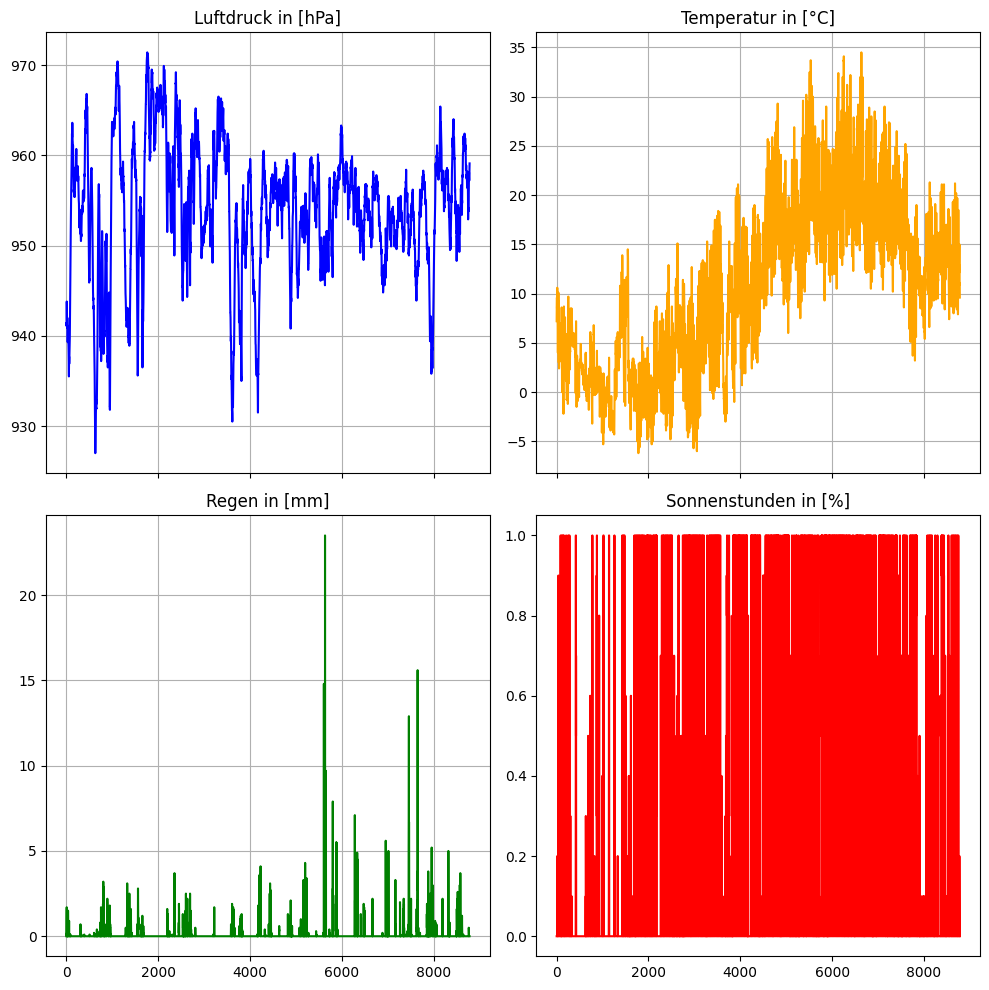

In [59]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=True)
titles = ['Luftdruck in [hPa]', 'Temperatur in [°C]', 'Regen in [mm]', 'Sonnenstunden in [%]']
data = [luftdruck, temperaturen, regen, sonne]
colors = ['blue', 'orange', 'green', 'red']

for i in range(4):
    row = i // 2
    col = i % 2
    axs[row, col].plot(messbeginn, data[i], color=colors[i])
    axs[row, col].set_title(titles[i])
    axs[row, col].grid()

plt.tight_layout()
plt.grid()
plt.show()


Auf die Umwandlung der "Stunden seit Messbeginn" in Datumsangaben wird im Moment verzichtet, da es sich erstmals um eine Übersicht handelt. 

## 2. Interpolation

Zuerst kontrollieren wir, ob die Arrays die selbe Länge haben. Ansonsten würde die Interpolation nicht funktionieren.

In [60]:
x_data = temperaturen
y_data = messbeginn
print(len(x_data))
print(len(y_data))

7464
7464


Die Interpolation haben wir hier mit der cubic-Methode durchgeführt. Dabei haben wir diese auf die Datenpunkte der Variablen "messbeginn", "temperaturen", "luftdruck", "regen" und "sonne" angewendet und als Listen abgespeichert.

In [61]:
# Eingabedaten als Listen 
x_list = ([messbeginn, messbeginn, messbeginn, messbeginn])
y_list = ([temperaturen, luftdruck, regen, sonne])

# Definiere die neuen x-Werte, für die interpoliert werden soll
x_neu = np.linspace(min([x.min() for x in x_list]), 
                    max([x.max() for x in x_list]), 
                    15_000) # Anzahl der Interpolationspunke 

# Interpoliere die y-Werte für die neuen x-Werte für jeden Eingabedatensatz
y_neu = [interp1d(x, y, kind="cubic")(x_neu) for x, y in zip(x_list, y_list)]

# Zeige nur die interpolierten Werte der jeweiligen Listen an
temperaturen_interpoliert = y_neu[0]
luftdruck_interpoliert = y_neu[1]
regen_interpoliert = y_neu[2]
sonne_interpoliert = y_neu[3]
temperaturen_interpoliert
print(temperaturen_interpoliert)

[ 7.20000000e+00  7.28332073e+00  7.61678606e+00  8.08919962e+00
  8.59144632e+00  9.04754278e+00  9.40806816e+00  9.62445254e+00
  9.68197822e+00  9.64834379e+00  9.60355131e+00  9.59424405e+00
  9.38021428e+00  8.79828868e+00  8.45463833e+00  8.66098058e+00
  9.03165068e+00  9.28935966e+00  9.31874058e+00  9.22047576e+00
  9.16246321e+00  9.30726752e+00  9.69829736e+00  1.02355782e+01
  1.06184893e+01  1.06096171e+01  1.04279067e+01  1.02442325e+01
  1.00462050e+01  9.80839669e+00  9.48265270e+00  8.92329078e+00
  8.21594734e+00  7.90151805e+00  7.98407964e+00  8.01015297e+00
  7.87269632e+00  7.60381328e+00  7.22782820e+00  6.86598871e+00
  6.73237055e+00  6.80168694e+00  6.86444082e+00  6.53256898e+00
  5.68270544e+00  4.70434684e+00  4.03550873e+00  4.00933508e+00
  4.37680301e+00  4.79462736e+00  5.17105650e+00  5.50134522e+00
  5.83548850e+00  6.22613489e+00  6.69423430e+00  7.15771665e+00
  7.66192185e+00  8.43615985e+00  9.27230093e+00  9.65107800e+00
  9.05146077e+00  7.59252

In [62]:
# Ausgabe des ganzen Array ohne Begrenzung 
np.set_printoptions(threshold=np.inf)
print(temperaturen_interpoliert)

[ 7.20000000e+00  7.28332073e+00  7.61678606e+00  8.08919962e+00
  8.59144632e+00  9.04754278e+00  9.40806816e+00  9.62445254e+00
  9.68197822e+00  9.64834379e+00  9.60355131e+00  9.59424405e+00
  9.38021428e+00  8.79828868e+00  8.45463833e+00  8.66098058e+00
  9.03165068e+00  9.28935966e+00  9.31874058e+00  9.22047576e+00
  9.16246321e+00  9.30726752e+00  9.69829736e+00  1.02355782e+01
  1.06184893e+01  1.06096171e+01  1.04279067e+01  1.02442325e+01
  1.00462050e+01  9.80839669e+00  9.48265270e+00  8.92329078e+00
  8.21594734e+00  7.90151805e+00  7.98407964e+00  8.01015297e+00
  7.87269632e+00  7.60381328e+00  7.22782820e+00  6.86598871e+00
  6.73237055e+00  6.80168694e+00  6.86444082e+00  6.53256898e+00
  5.68270544e+00  4.70434684e+00  4.03550873e+00  4.00933508e+00
  4.37680301e+00  4.79462736e+00  5.17105650e+00  5.50134522e+00
  5.83548850e+00  6.22613489e+00  6.69423430e+00  7.15771665e+00
  7.66192185e+00  8.43615985e+00  9.27230093e+00  9.65107800e+00
  9.05146077e+00  7.59252

Zur Visualisierung haben wir Diagramme erstellt, die sowohl die originalen als auch die interpolierten Daten für jede Variable darstellen. Jede Variable ist dabei in einem eigenen Subplot dargestellt, mit den Originaldaten in Rot und den interpolierten Daten in Blau.

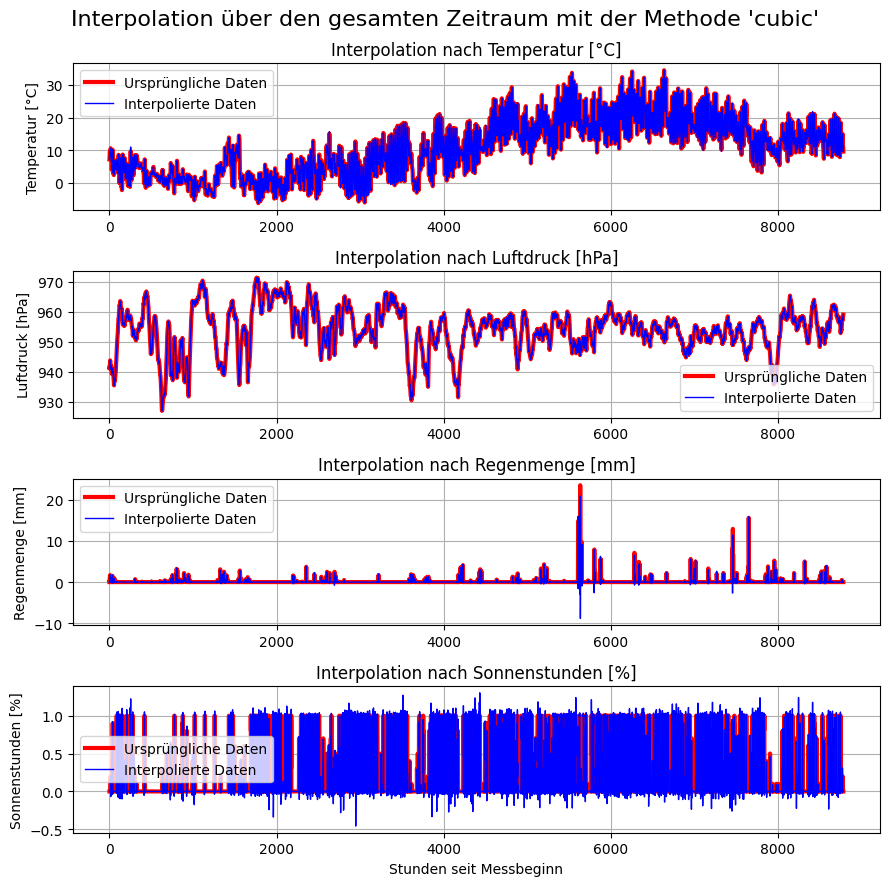

In [63]:
# Eingabedaten als Listen 
x_list = ([messbeginn, messbeginn, messbeginn, messbeginn])
y_list = ([temperaturen, luftdruck, regen, sonne])

# Definiere Y Achsennamen
y_listnames = (["Temperatur [°C]", "Luftdruck [hPa]", "Regenmenge [mm]", "Sonnenstunden [%]"])

# Definiere die neuen x-Werte, für die interpoliert werden soll
x_neu = np.linspace(min([x.min() for x in x_list]), 
                    max([x.max() for x in x_list]), 
                    15_000) #Anzahl Interpolationspunkte 

# Interpoliere die y-Werte für die neuen x-Werte für jeden Eingabedatensatz
y_neu = [interp1d(x, y, kind="cubic")(x_neu) for x, y in zip(x_list, y_list)]

# Plotte die interpolierten Kurven auf verschiedenen Subplots
fig, axs = plt.subplots(len(y_list), (1), figsize=(9, 9))

for i, (x, y, y_neu) in enumerate(zip(x_list, y_list, y_neu)):
    axs[i].plot(x, y, "-", color="red", linewidth=3, label="Ursprüngliche Daten")
    axs[i].plot(x_neu, y_neu,color="blue", linewidth=1,  label="Interpolierte Daten")
    axs[i].legend()
    axs[i].grid()
    axs[i].set_ylabel(f"{y_listnames[i]}")
    axs[i].set_title(f"Interpolation nach {y_listnames[i]}")

fig.suptitle("Interpolation über den gesamten Zeitraum mit der Methode 'cubic'", size= 16)
plt.xlabel("Stunden seit Messbeginn")
plt.tight_layout()
plt.show()

Um eine klarere Darstellung zu erhalten und den Unterschied besser erkennen zu können, haben wir entschlossen, einen kürzeren Zeitraum zu plotten. Die aktuelle Darstellung ist aufgrund der doppelten Interpolationspunkte etwas überladen und erschwert die Betrachtung der ursprünglichen Daten.


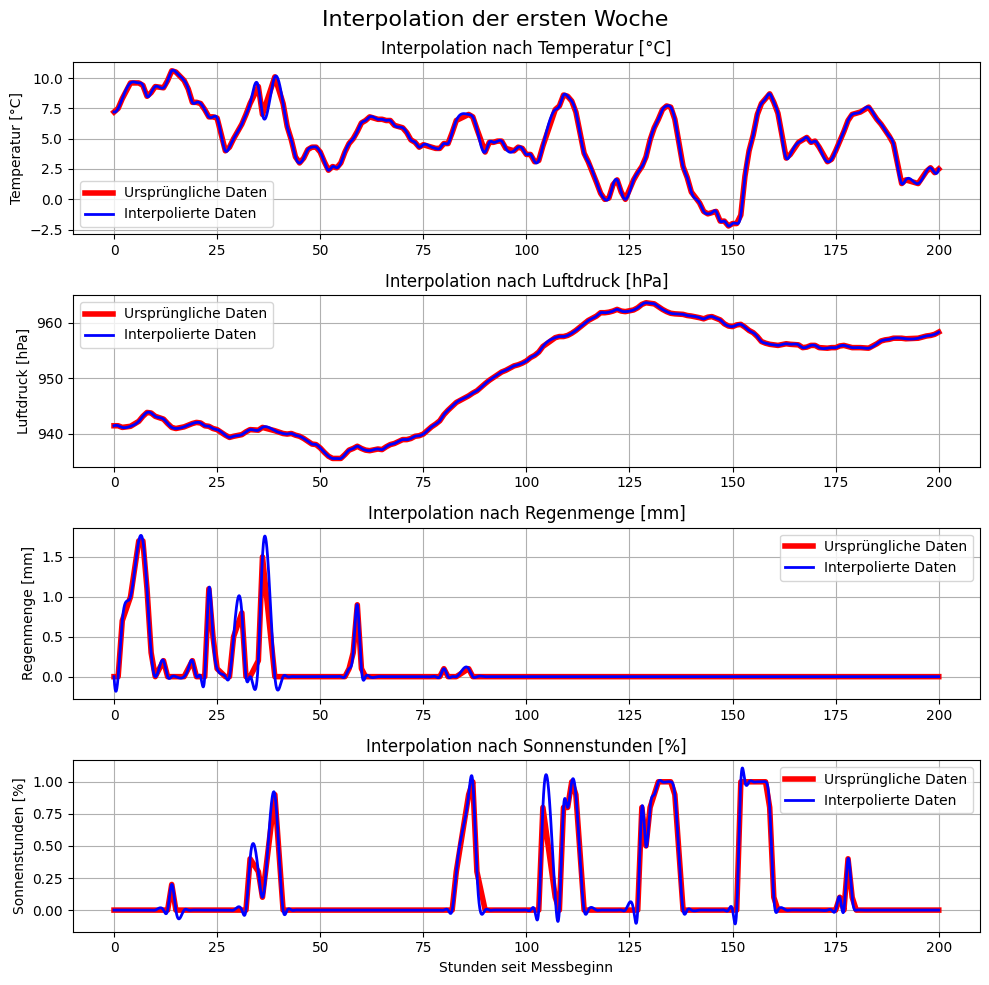

In [64]:
# Liste mit dem gefilterten Zeitraum von einer Woche
x_list = ([messbeginn[:168], messbeginn[:168], messbeginn[:168], messbeginn[:168]])
y_list = ([temperaturen[:168], luftdruck[:168], regen[:168], sonne[:168]])

# Definiere Y-Achsennamen
y_listnames = (["Temperatur [°C]", "Luftdruck [hPa]", "Regenmenge [mm]", "Sonnenstunden [%]"])

# Definiere die neuen x-Werte, für die interpoliert werden soll
x_neu = np.linspace(min([x.min() for x in x_list]), 
                    max([x.max() for x in x_list]), 
                    15_000)

# Interpoliere die y-Werte für die neuen x-Werte für jeden Eingabedatensatz
y_neu = [interp1d(x, y, kind="cubic")(x_neu) for x, y in zip(x_list, y_list)]

# Plotte die interpolierten Kurven auf verschiedenen Subplots
fig, axs = plt.subplots(len(y_list), (1), figsize=(10,10))

for i, (x, y, y_neu) in enumerate(zip(x_list, y_list, y_neu)):
    axs[i].plot(x, y, "-", color="red", linewidth=4, label="Ursprüngliche Daten")
    axs[i].plot(x_neu, y_neu,color="blue", linewidth=2,  label="Interpolierte Daten")
    axs[i].legend()
    axs[i].grid()
    axs[i].set_ylabel(f"{y_listnames[i]}")
    axs[i].set_title(f"Interpolation nach {y_listnames[i]}")

fig.suptitle('Interpolation der ersten Woche',size = 16) 
plt.xlabel("Stunden seit Messbeginn")
plt.tight_layout()
plt.show()

###  Wieso Cubic?
Die Auswahl der Interpolation hängt von vielen Faktoren ab. Es kommt auf die Anzahl der Datenpunkte an, welche man interpolieren will. Cubic ist eine Interpolationsmethode der höheren Ordnung. Aus diesem Grund haben wir uns entschieden, diese Methode zu verwenden. Zusätzlich ermöglicht Cubic die Glättung der Funktionen bei vielen Datenpunkten, da sie auf einer kubischen Spline-Interpolation basiert bei welcher stückweise kubische Polynome verwendet werden, um eine Kurve zu approximieren. Andere Interpolationsmethoden der niedrigeren Ordnung wie lineare oder quadratische Polynome führen zu schritt-förmigen Interpolationen und ermöglichen keine so glatte Kurve.

#### Weitere verschiedenen Interpolationsmethoden:

- ``linear``: lineare Interpolation
- ``nearest``: Interpolation durch den nächstgelegenen Nachbarn
- ``zero``: Interpolation durch Nullen
- ``slinear``: Interpolation mit stückweise linearer Funktion
- ``quadratic``: Interpolation mit stückweise quadratischer Funktion
- ``cubic``: Interpolation mit stückweise kubischer Funktion
- ``previous``: Interpolation durch den vorherigen Wert
- ``next``: Interpolation durch den nächsten Wert

### Bedingter Ausdruck (Ternary Operator) in Python
<details>
  <summary> Gelernte weitere Fakten/Informationen während des Projekts (1)</summary>

[Ternary Operator in Python](https://www.geeksforgeeks.org/ternary-operator-in-python/)

- Der bedingte Ausdruck ist eine elegante Möglichkeit, eine Verzweigung in einer Zeile Code auszudrücken.

- Dieser Ausdruck besteht aus einer Bedingung, einem Ergebnis, wenn die Bedingung wahr ist, und einem anderen Ergebnis, wenn die Bedingung falsch ist.

- Die Syntax des bedingten Ausdrucks lautet:
            **`` result_if_true if condition else result_if_false``**.

- Die Verwendung des bedingten Ausdrucks kann die Lesbarkeit des Codes erhöhen, insbesondere wenn die Bedingung und die Ergebnisse kurz und einfach sind.

- Der bedingte Ausdruck ist oft nützlich, um Werte abhängig von einer Bedingung zuzuweisen oder um Optionen auszuwählen, wenn Eingabe-Argumente variabel sind.

- Es ist jedoch *wichtig* zu beachten, dass eine ausführliche if-else Anweisung in manchen Fällen den Code leichter verständlich macht als ein bedingter Ausdruck, insbesondere wenn es mehrere Bedingungen gibt oder zu einem späteren Zeitpunkt gewartet wird. 


</details>

## 3. Darstellung der Parameter ``temperatur``, ``luftdruck``, ``regen``, ``sonne`` über einen gewählten Zeitraum 

Wir haben uns entschieden, die täglichen Durchschnitte zu berechnen, damit die Parameter in einem grösseren Zeitraum dargestellt werden können. Hierfür haben wir die Funktion "daily_averages" definiert. Dafür wurden die Stunden seit Messbeginn und die zugehörigen Werte herangezogen. Mit Hilfe des `datetime`-Moduls wurden die zugehörigen Tage zu den Durchschnittswerten ermittelt.

In [65]:
def daily_averages(hours_since_start, values):
    """
    Berechnet den Tagesdurchschnitt basierend auf den Stunden seit Messbeginn und den zugehörigen Werten.

    Args:
        hours_since_start (list): Eine Liste von Stunden seit dem Startpunkt der Messungen.
        values (list): Eine Liste von Werten, die den Messungen zu den entsprechenden Stunden entsprechen.

    Returns:
        tuple: Ein Tupel, das aus zwei Listen besteht:
            - dates: Eine Liste von Datumswerten, die den jeweiligen Tagen der Tagesdurchschnitte entsprechen.
            - daily_averages: Eine Liste von Tagesdurchschnittswerten, berechnet aus den übergebenen Werten.
    """
    start_time = dt.datetime(2021, 11, 1)  # Der erste Messwert wurde am 1. November 2021 um 00:00 Uhr gemessen
    # Tagesdurchschnitt der Werte berechnen
    daily_averages = []
    dates = []
    current_date = start_time.date()
    daily_values = []
    for hour, val in zip(hours_since_start, values):
        date = start_time + dt.timedelta(hours=hour)
        date = date.date()
        if date != current_date:
            daily_averages.append(sum(daily_values) / len(daily_values))
            daily_values = []
            dates.append(current_date)
            current_date = date
        daily_values.append(val)
    daily_averages.append(sum(daily_values) / len(daily_values))
    dates.append(current_date)

    return dates, daily_averages


In [66]:
# Berechnen der einzelnen Tagesdurchschnitte der Parameter

datum, avg_temperatur = daily_averages(messbeginn, temperaturen)
datum, avg_luftdruck = daily_averages(messbeginn, luftdruck)
datum, avg_regen = daily_averages(messbeginn, regen)
datum, avg_sonne = daily_averages(messbeginn, sonne)

Schauen wir uns nun die Tagesdurchschnitte der Parameter an, um zu entscheiden, welcher Zeitraum interessant sein könnte:

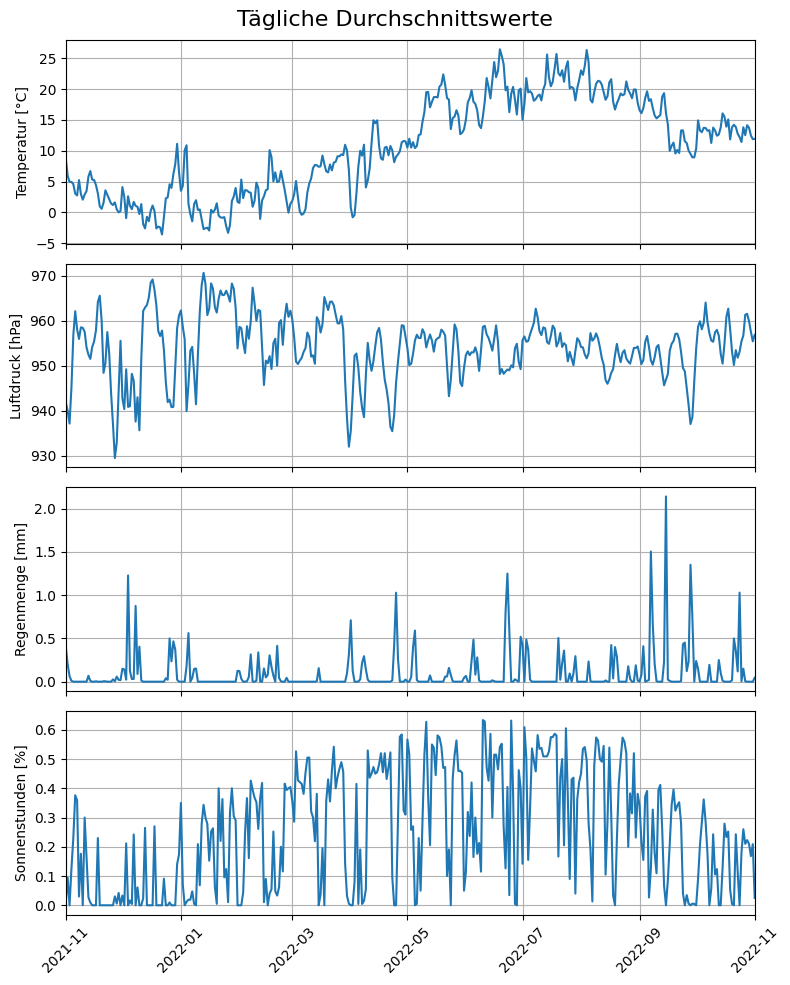

In [67]:
num_subplots = 4
figsize = (8, 10)
sharex = True

# Erstelle die Subplots
fig, axs = plt.subplots(num_subplots, 1, figsize=figsize, sharex=sharex)

# Daten für die Subplots
data = {'Temperatur [°C]': avg_temperatur,
        'Luftdruck [hPa]': avg_luftdruck,
        'Regenmenge [mm]': avg_regen,
        'Sonnenstunden [%]': avg_sonne}

# Schleife über die Subplots
for i, (ylabel, ydata) in enumerate(data.items()):
    axs[i].plot(datum, ydata)
    axs[i].set_ylabel(ylabel)
    axs[i].grid()

fig.suptitle('Tägliche Durchschnittswerte', size = 16) 
plt.xticks(rotation=45)
plt.xlim(datum[0], datum[-1])
plt.tight_layout()
plt.show()

Um die verschiedenen Messwerte in der gewünschten Zeitspanne filtern zu können, erstellen wir eine Funktion. Diese gibt uns danach die gefiltern Durchschnittswerte und die dazugehörigen Datumsangaben aus, welche wir verwenden können, um einen Plot zu erstellen.

In [68]:
def zeitraum_filtern(avg_messwerte, datum_angaben, start_datum, end_datum):
    """
    Ausgabe der gefilterten Daten für einen bestimmten Zeitraum
    
    Parameter:
    avg_messwerte (liste): Liste der durchschnittlichen Messwerte
    
    datum_angaben (liste): Liste von datetime Objekten entsprechend den Messwerten
    
    start_datum (str or datetime.datetime): Startdatum des Zeitraums, der gefiltert werden soll
    
    end_datum (str or datetime.datetime): Enddatum des Zeitraums, der gefiltert werden soll
    """
    # start_datum und end_datum in datetime Objekte umwandeln (wenn Eingabe als string)
    if isinstance(start_datum, str):
        start_datum = dt.datetime.strptime(start_datum, '%Y-%m-%d').date()
    if isinstance(end_datum, str):
        end_datum = dt.datetime.strptime(end_datum, '%Y-%m-%d').date()
    
    # Messwerte und Datumswerte filtern, die innerhalb des angegebenen Zeitraums liegen
    avg_werte_filtriert = []
    datum_filtriert = []
    for wert, datum in zip(avg_messwerte, datum_angaben):
        if start_datum <= datum <= end_datum:
            avg_werte_filtriert.append(wert)
            datum_filtriert.append(datum)
    
    return datum_filtriert, avg_werte_filtriert

### ``isinstance() ``in Python
<details>
  <summary> Gelernte weitere Fakten/Informationen über die isinstance Funktion während des Projekts (2)</summary>

[`isinstance()` in Python ](https://pynative.com/python-isinstance-explained-with-examples/)

- `isinstance()` ist eine Funktion in Python die wird verwendet, um den  Datentyp einer Variablen zu überprüfen

- Sie nimmt zwei Argumente: die zu prüfende Variable und den zu überprüfenden Datentyp

- Die Funktion gibt ``True`` zurück, wenn die Variable den angegebenen Datentyp hat, andernfalls gibt sie `False` zurück
    
- Die Verwendung von isinstance() ist **wichtig**, um *Fehler* zu vermeiden und sicherzustellen, dass der Code korrekt funktioniert
  
- Sie kann dazu beitragen, Programmabstürze zu verhindern
    isinstance() wird auch verwendet, um Benutzereingaben zu überprüfen


</details>

Wir haben uns entschieden, den Zeitraum September und Oktober 2022 genauer zu betrachten, da wir dann die grösste Regenmenge beochbachten konnten.

In [69]:
# Filtern der Daten für einen bestimmten Zeitraum
filt_datum, filt_temp = zeitraum_filtern(avg_temperatur, datum, '2022-09-01', '2022-10-31')
filt_datum, filt_luftdruck = zeitraum_filtern(avg_luftdruck, datum, '2022-09-01', '2022-10-31')
filt_datum, filt_regen = zeitraum_filtern(avg_regen, datum, '2022-09-01', '2022-10-31')
filt_datum, filt_sonne = zeitraum_filtern(avg_sonne, datum, '2022-09-01', '2022-10-31')

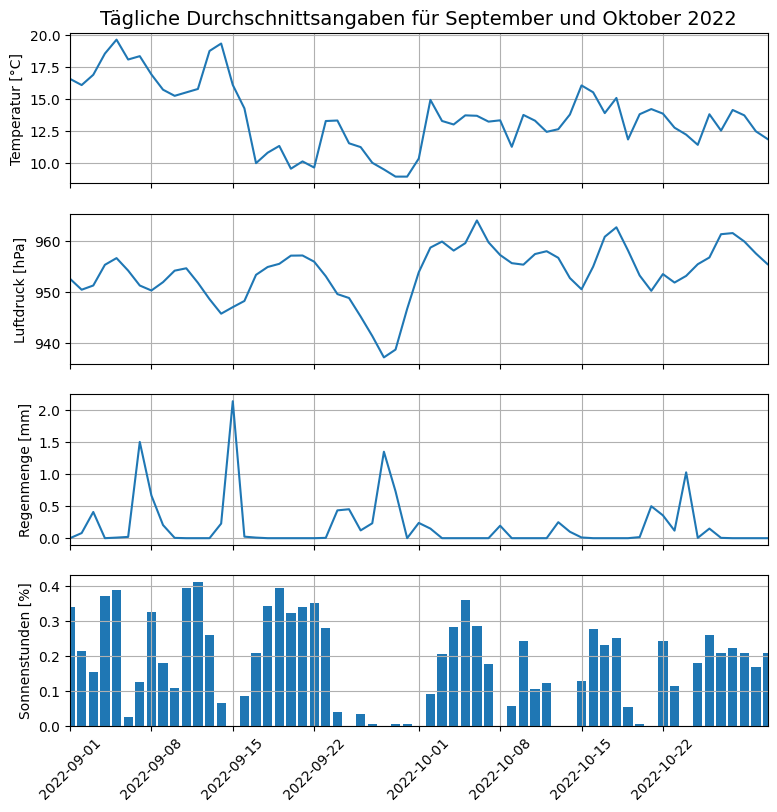

In [70]:
# Subplots erstellen
fig, axs = plt.subplots(4, 1, figsize=(9, 9), sharex=True)

# Subplot-Einstellungen
subplot_settings = [
    {'data': filt_temp, 'ylabel': 'Temperatur [°C]', 'title': 'Tägliche Durchschnittsangaben für September und Oktober 2022', 'plot_func': axs[0].plot},
    {'data': filt_luftdruck, 'ylabel': 'Luftdruck [hPa]', 'plot_func': axs[1].plot},
    {'data': filt_regen, 'ylabel': 'Regenmenge [mm]', 'plot_func': axs[2].plot},
    {'data': filt_sonne, 'ylabel': 'Sonnenstunden [%]', 'plot_func': axs[3].bar},
]

for i, settings in enumerate(subplot_settings):
    # Daten und Plot-Funktion aus den Einstellungen auslesen
    data = settings['data']
    plot_func = settings['plot_func']
    
    # Plot erstellen
    plot_func(filt_datum, data) 
    
    # Achsenbeschriftungen und Gitter hinzufügen 
    axs[i].set_ylabel(settings['ylabel'])
    axs[i].set_xlim(np.min(filt_datum), np.max(filt_datum))
    axs[i].grid()
    
    # Titel setzen (nur für erstes Subplot)
    if i == 0:
        axs[i].set_title(settings['title'], size= 14)

plt.xticks(rotation=45)
plt.show()


## 4. Vergleich der ursprünglichen Daten mit den interpolierten Daten und Erkenntnisse

Wir haben uns entschieden mindestens zwei Punkte zu wählen, damit man jeweils besser und schneller erkennen kann, wo es Veränderungen gibt um dann genauere Rückschlüsse zu ziehen.

Wenn man die Interpolation auf die ganze Messzeit anwendet, sieht man kaum einen Unterschied. Aus diesem Grund können die `num_points` selber gewählt werden. 

Wir haben uns bei dem Vergleich der ursprünglichen Daten mit den interpolierten Daten für die Methode 'Next' entschieden, da es unserer Meinung nach die Unterschiede am besten visualisiert. Vor allem bei der Temperatur ist es klar ersichtlich, dass die Interpolationsmethode nicht jener Interpolationsmethode entspricht, welche am Anfang festgelegt wurde.

In [71]:
def div_interp_methods(x_list, y_list, interpolation_type="cubic", num_points=1000): 
    """
    Interpoliert die Eingabedaten und plottet die interpolierten Kurven auf verschiedenen Subplots.

    Parameter
    ---------
    x_list : Liste von Array
        Eine Liste von x-Koordinaten für jeden Eingabedatensatz.
    y_list : Liste von Array
        Eine Liste von y-Koordinaten für jeden Eingabedatensatz.
    interpolation_type : str, optional (Standardwert: "cubic")
    
    num_points : int, optional (Standardwert: 1000)
        Die Anzahl der zu generierenden Messzeitpunkte.

    Rückgabe
    --------
    Plot
    """
    
    # Definiere die neuen x-Werte, für die interpoliert werden soll
    x_min = min([x.min() for x in x_list])
    x_max = max([x.max() for x in x_list])
    x_neu = np.linspace(x_min, x_max, num_points)

    # Interpoliere die y-Werte für die neuen x-Werte für jeden Eingabedatensatz
    y_neu = [interp1d(x, y, kind=interpolation_type)(x_neu) for x, y in zip(x_list, y_list)]

    # Definiere y-Achsen Namen
    y_listnames = (["Temperatur [°C]", "Luftdruck [hPa]", "Regenmenge [mm]", "Sonnenstunden [%]"])

    # Plotte die interpolierten Kurven auf verschiedenen Subplots
    fig, axs = plt.subplots(len(y_list), (1), figsize=(8, 8))

    for i, (x, y, y_neu) in enumerate(zip(x_list, y_list, y_neu)):
        axs[i].plot(x, y, "-", label="Ursprüngliche Daten")
        axs[i].plot(x_neu, y_neu, label=f"Interpolierte Funktion ({interpolation_type})")
        axs[i].legend()
        axs[i].grid()
        axs[i].set_ylabel(f"{y_listnames[i]}")
        axs[i].set_title(f"Interpolation nach {y_listnames[i]}")

    fig.suptitle(f"Interpolation mit der Methode '{interpolation_type}'", size = 16)
    plt.xlabel("Stunden seit Messbeginn")
    plt.tight_layout()
    plt.show()

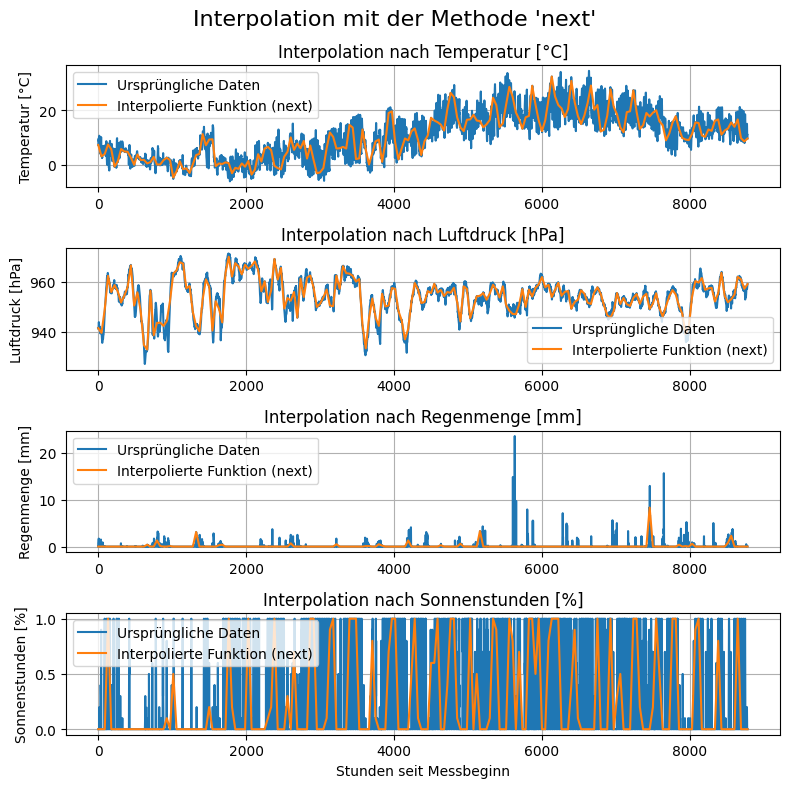

In [72]:
div_interp_methods([messbeginn, messbeginn, messbeginn, messbeginn],
                       [temperaturen, luftdruck, regen, sonne], interpolation_type="next", num_points=200)

Da uns die Umwandlung der Messdaten "Stunden seit Messbeginn" in datetime-Objekte für die Interpolation Schwierigkeiten bereitet hat, haben wir uns in Schritt 5 entschieden, dies als "Stunden seit Messbeginn" zu belassen. In Schritt 3 wurde allerdings die Umwandlung durchgeführt und auch bei der Visualisierung der Messdaten miteinbezogen. 

 Da bei dem oben visualierten Vergleich die Unterschiede nicht direkt klar erkennbar sind, haben wir uns entschieden, uns auf einen gewählten Zeitraum und den Parameter Temperatur zu beschränken.


## 4.1 Vergleich zwischen der next-Methode und der cubic-Methode

### Vergleich mit ``NEXT``

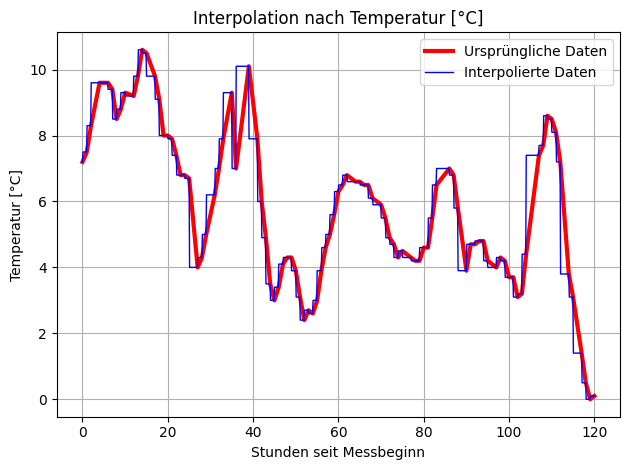

In [73]:
# Zusammenführen von Messbeginn und Temperaturen zu einer Liste
y_list = [temperaturen[:100]]

# Definiere y-Achsennamen
y_listnames = (["Temperatur [°C]"])

# Definiere die neuen x-Werte, für welche interpoliert werden soll
x_list = [messbeginn[:100]]

x_neu = np.linspace(min([x.min() for x in x_list]), 
                    max([x.max() for x in x_list]), 
                    1000) # erhöhte Anzahl an interpolierten Werten

# Interpoliere die y-Werte für die neuen x-Werte
y_neu = [interp1d(x_list[0], y_list[0], kind="next")(x_neu)]

plt.plot(x_list[0][:100], y_list[0][:100], "-", color="red", linewidth=3, label="Ursprüngliche Daten")
plt.plot(x_neu[:1000], y_neu[0][:1000], color="blue", linewidth=1, label="Interpolierte Daten")

plt.legend()
plt.xlabel("Stunden seit Messbeginn")
plt.ylabel(f"{y_listnames[0]}")
plt.title(f"Interpolation nach {y_listnames[0]}")

plt.tight_layout()
plt.grid()
plt.show()

### Vergleich mit ``CUBIC``

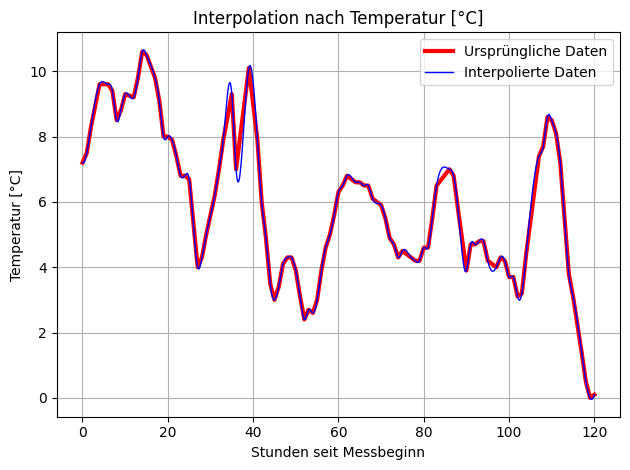

In [74]:
# Zusammenführen von Messbeginn und Temperaturen zu einer Liste
y_list = [temperaturen[:100]]

# Definiere y-Achsennamen
y_listnames = (["Temperatur [°C]"])

# Definiere die neuen x-Werte, für welche interpoliert werden soll
x_list = [messbeginn[:100]]

x_neu = np.linspace(min([x.min() for x in x_list]), 
                    max([x.max() for x in x_list]), 
                    1000) # erhöhte Anzahl an interpolierten Werten

# Interpoliere die y-Werte für die neuen x-Werte
y_neu = [interp1d(x_list[0], y_list[0], kind="cubic")(x_neu)]

plt.plot(x_list[0][:100], y_list[0][:100], "-", color="red", linewidth=3, label="Ursprüngliche Daten")
plt.plot(x_neu[:1000], y_neu[0][:1000], color="blue", linewidth=1, label="Interpolierte Daten")

plt.legend()
plt.xlabel("Stunden seit Messbeginn")
plt.ylabel(f"{y_listnames[0]}")
plt.title(f"Interpolation nach {y_listnames[0]}")

plt.tight_layout()
plt.grid()
plt.show()

### Erkenntnisse aus dem Methodenvergleich
Bei genauerem Betrachten ist klar erkennbar, dass die cubic Interpolation exakter ist. Trotzdem zeigt sie an einigen Punkten eindeutige Unterschiede. Die ursprünglichen Messwerte sind teilweise höher oder tiefer als die Interpolationswerte. Erwähnenswert ist ebenfalls, dass bei einer höheren Anzahl Punkten für die Interpolation der Graph "glatter" wird. Gut erkennbar ist dies bei den Messpunkten zwischen 20 und 40. Diese Glättung des Graphen ist auf die Interpolation zurückzuführen, denn die Interpolation ermöglicht es, Lücken in den Daten zu füllen. Zudem ist zu beachten, dass die Genauigkeit der Interpolation davon abhängt, wie nahe die ursprünglichen Datenpunkte beieinander liegen. In diesem Beispiel ist dies weniger störend, da die Messungen jeweils im Stundentakt erfolgt sind.

## 5. Nullstellen bzw. Schnittpunkte mit Schwellenwert


Zuerst haben wir die Nullstellen der Temperaturdaten berechnet

Der Schwellenwert von 0 °C wurde 26 mal überschritten.


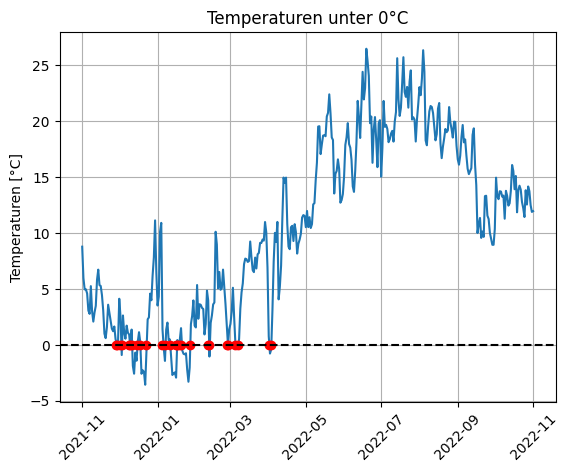

In [75]:
# Temperaturen unter 0°C
nullstellen = []
for i in range(len(avg_temperatur)-1):
    if avg_temperatur[i] * avg_temperatur[i+1] <= 0:
        nullstellen.append(datum[i])
        
# Anzahl der Schwellenwert-Überschreitungen ausgeben
print(f'Der Schwellenwert von 0 °C wurde {len(nullstellen)} mal überschritten.')
      
# Visualisierung der Temperaturen unter 0°C
plt.plot(datum, avg_temperatur)
plt.plot(nullstellen, [0]*len(nullstellen), 'ro')
#plt.xlabel('Datumsangaben')
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(rotation=45)
plt.ylabel('Temperaturen [°C]')
plt.title('Temperaturen unter 0°C')
plt.grid()
plt.show()

Uns interessiert jedoch, in welchen Jahreszeiten die Temperatur unter 0°C war. Zusätzlich wollen wir herausfinden, wie oft diese Bedingungen erfüllt wurden.

In [76]:
def unter_null(zahlen):
    """
    Zählt, wie oft ein Wert in einer Liste kleiner oder gleich 0 ist.

    Args:
        zahlen (list): Eine Liste von Zahlen.

    Returns:
        int: Die Anzahl der Zahlen in der Liste, die kleiner oder gleich 0 sind.
    """
    unter_null = 0
    for i in range(len(zahlen)):
        if zahlen[i] <= 0:
            unter_null += 1
    return unter_null

In [77]:
def get_seasonal_avg_temperatures(data, start_month, end_month):
    """
    Berechnet die durchschnittlichen saisonalen Temperaturen basierend auf den übergebenen Daten und dem angegebenen
    Start- und Endmonat.

    Args:
        data (list): Eine Liste von Datenpunkten, die die Temperaturwerte enthalten.
        start_month (int): Der Startmonat der saisonalen Periode (einschliesslich).
        end_month (int): Der Endmonat der saisonalen Periode (einschliesslich).

    Returns:
        list: Eine Liste von durchschnittlichen saisonalen Temperaturen, die innerhalb des angegebenen Zeitraums liegen.
    """
    seasonal_temperatures = []
    for i in range(len(data)):
        if data[i].month in range(start_month, end_month+1):
            seasonal_temperatures.append(avg_temperatur[i])
    return seasonal_temperatures

winter = get_seasonal_avg_temperatures(datum, 12, 2)
fruehling = get_seasonal_avg_temperatures(datum, 3, 5)
sommer = get_seasonal_avg_temperatures(datum, 6, 8)
herbst = get_seasonal_avg_temperatures(datum, 9, 11)


seasons = [("Winter", [12, 1, 2]), 
           ("Frühling", [3, 4, 5]), 
           ("Sommer", [6, 7, 8]), 
           ("Herbst", [9, 10, 11])]

for season, months in seasons:
    temps = []
    for i in range(len(datum)):
        if datum[i].month in months:
            temps.append(avg_temperatur[i])
    print(f"In Bern hatten wir im {season} {unter_null(temps)} mal weniger als 0°C.")


In Bern hatten wir im Winter 28 mal weniger als 0°C.
In Bern hatten wir im Frühling 4 mal weniger als 0°C.
In Bern hatten wir im Sommer 0 mal weniger als 0°C.
In Bern hatten wir im Herbst 1 mal weniger als 0°C.


Der Schwellenwert von 10 mm wurde 7 mal überschritten.


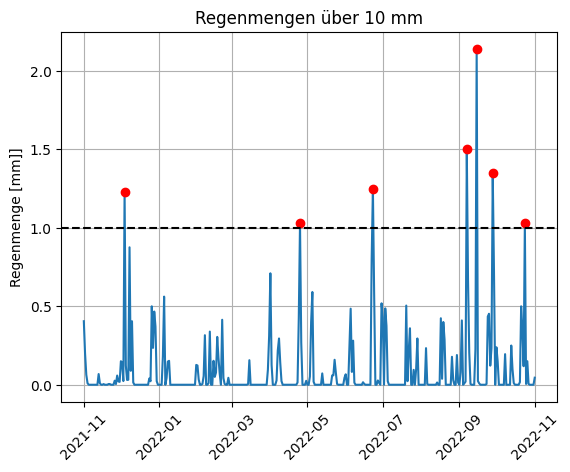

In [78]:
# Filtern der Regendaten, die über 10 mm liegen
filt_datum_regen = []
regen_ueber_10 = []
for i in range(len(avg_regen)):
    if avg_regen[i] > 1.0:
        filt_datum_regen.append(datum[i])
        regen_ueber_10.append(avg_regen[i])

# Anzahl der Schwellenwert-Überschreitungen ausgeben
print(f'Der Schwellenwert von 10 mm wurde {len(regen_ueber_10)} mal überschritten.')
      
# Visualisierung der Regendaten über 10 mm
plt.plot(datum, avg_regen)
plt.plot(filt_datum_regen, regen_ueber_10, 'ro')
plt.axhline(y=1, color='black', linestyle='--')
plt.xticks(rotation=45)
plt.ylabel('Regenmenge [mm]]')
plt.title('Regenmengen über 10 mm')
plt.grid()
plt.show()

In diesem Beispiel wollen wir den User nach einem bestimmten Wert fragen. Es wird nach denjenigen Werten der Regenmenge gesucht, welche über dem Wert liegen, die der User eingegeben hat.
**Der Wert darf jedoch nicht unter 0 sein.**

An den Tagen 04.12.2021, 08.12.2021, 01.04.2022, 25.04.2022, 22.06.2022, 23.06.2022, 07.09.2022, 15.09.2022, 28.09.2022, 29.09.2022, 24.10.2022 wurde die Regenmenge von 0.7 erreicht.


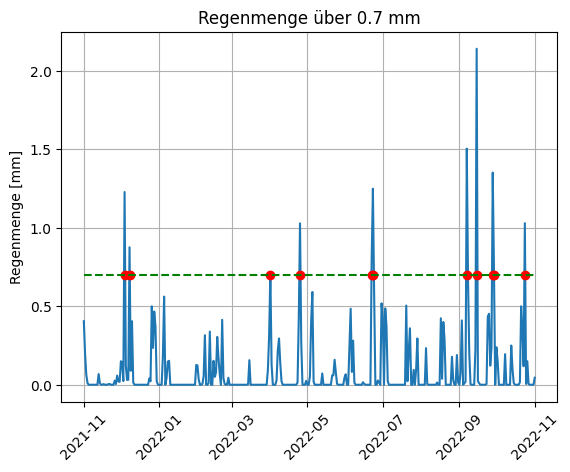

In [79]:
# Eingabe der Regenmenge
regenwert = 0.7  # float(input('Geben Sie einen Regenwert > 0 ein: '))

# Suche nach Tagen, an denen die Regenmenge erreicht wurde
regenwert_regen = []
for i in range(len(avg_regen)):
    if avg_regen[i] > regenwert:
        regenwert_regen.append(datum[i].strftime("%d.%m.%Y"))

# Ausgabe
if len(regenwert_regen) == 0:
    print(f"Der Regenwert {regenwert} wurde nicht erreicht.")
elif len(regenwert_regen) == 1:
    print(
        f"An dem Tag {regenwert_regen[0]} wurde eine Regenmenge von {regenwert} erreicht."
    )
else:
    print(
        f'An den Tagen {", ".join(regenwert_regen)} wurde die Regenmenge von {regenwert} erreicht.'
    )

# Visualisierung
plt.plot(datum, avg_regen)
plt.plot(
    [d for d in datum if d.strftime("%d.%m.%Y") in regenwert_regen],
    [regenwert] * len(regenwert_regen),
    "ro",
)
plt.plot(datum, [regenwert]*len(datum), 'g--')
plt.ylabel("Regenmenge [mm]")
plt.title(f"Regenmenge über {regenwert} mm")
plt.xticks(rotation=45)
plt.grid()
plt.show()


Der Schwellenwert von 940 hPa wurde 17 mal überschritten.


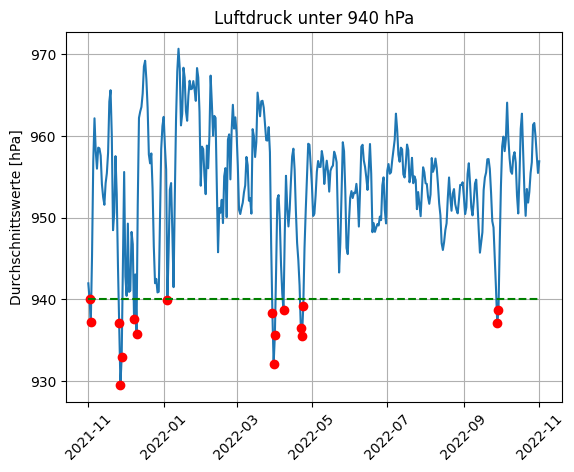

In [80]:
# Filtern der Luftdruckdaten, die unter 940 hPa liegen
filt_datum_luftdruck = []
luftdruck_unter_940 = []
for i in range(len(avg_luftdruck)):
    if avg_luftdruck[i] <940:
        filt_datum_luftdruck.append(datum[i])
        luftdruck_unter_940.append(avg_luftdruck[i])
        
# Anzahl der Schwellenwert-Überschreitungen ausgeben
print(f'Der Schwellenwert von 940 hPa wurde {len(luftdruck_unter_940)} mal überschritten.')
      
# Visualisierung der Luftdruckdaten unter 940 hPa
plt.plot(datum, avg_luftdruck)
plt.plot(filt_datum_luftdruck, luftdruck_unter_940, 'ro')
plt.plot(datum, [940]*len(datum), 'g--')
plt.ylabel('Durchschnittswerte [hPa]')
plt.title('Luftdruck unter 940 hPa')
plt.xticks(rotation=45)
plt.grid()
plt.show()


### Hochdruck und Tiefdruck 
<details>
  <summary> Was sind Hoch- und Tiefdruckgebiete? (3)</summary>

[Quelle ](https://www.wetterstation.net/hochdruck-tiefdruck/)

Mit Luftdruck bezeichnet man hauptsächlich die Kompression der Luft in der Atmosphäre. Durch unterschiedliche Temperaturbereiche entstehen auch unterschiedliche Luftdrücke.

Bei erhöhten Temperaturen dehnt sich die Luft aus, das Gegenteil passiert bei tiefen Temperaturen. Dieses Zusammenspiel hat einen Einfluss auf das Wetter. 

**So entsteht ein Hochdruckgebiet**

Ein Hochdruckgebiet entsteht, wenn kältere Luftmassen über wärmere geschoben werden und dadurch der Druck in den unteren Luftmassen zunimmt. Die Luft erwärmt sich und dehnt sich aus, strömt nach aussen und es entsteht eine Luftmassenkonvergenz. Dabei strömt Luft aus höher gelegenen Schichten in das Hochdruckgebiet hinein, um die entweichenden Luftmassen zu ersetzen. Dadurch erwärmt sich die Luft und es entsteht keine Wolkenbildung.

**So entsteht ein Tiefdruckgebiet**

Ein Tiefdruckgebiet entsteht, wenn warme Luftschichten aufsteigen und sich in der Atmosphäre verteilen, wodurch der Luftdruck in Bodennähe abnimmt. Die aufsteigenden Luftmassen kühlen ab und nehmen auf ihrem Weg nach oben Wasser auf, wodurch Wolken entstehen. Die Wolken reduzieren die Sonneneinstrahlung auf die Erde und es wird kälter, während es häufiger regnet.



|       | **Erklärung** |
| ----------- | ----------- |
| Hochdruckgebiet      | In einem Hochdruckgebiet fliesst in der Höhe mehr Luft hinein als am Erdboden abfliesst, daher lastet auf dem Erdboden mehr Luft als normalerweise. Dadurch steigt der Luftdruck.     |
| Tiefdruckgebiet  | In diesem Fall fliesst in der Höhe mehr Luft ab, als am Erdboden hinein fliesst. Der Luftdruck ist dadurch geringer als im Normalfall.     |
</details>

## 6. Durch Ableitung nach grossen Änderungen in den Daten suchen

Durch den Einsatz der Funktion np.gradient() haben wir die Ableitungen der Luftdruck-, Temperatur-, Sonnenschein- und Regenmengendaten berechnet. Dieser Ansatz erlaubte es uns, die Tage mit den höchsten und niedrigsten Änderungsraten in diesen Kategorien zu identifizieren.

Die Visualisierungen dieser Ableitungen machten die dynamischen Veränderungen dieser Parameter über die Zeit sichtbar.

Durch die Suche nach den größten Veränderungen haben wir bestimmte Zeitpunkte identifiziert, in denen signifikante Wetterereignisse stattgefunden haben.

Am Tag 11.12.2021 hatten wir die höchste Änderungsrate des Luftdrucks. 
Am Tag 29.03.2022 hatten wir die niedrigste  Änderungsrate des Luftdrucks.


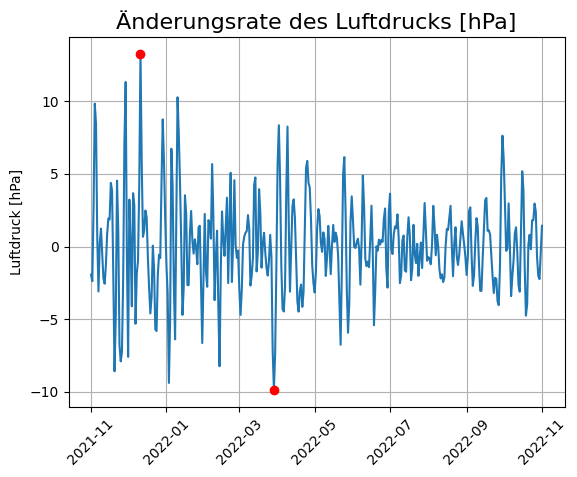

In [81]:
# Liste mit Datumsangaben
val = avg_luftdruck
daten = datum

# Berechnung der Ableitung mit np.gradient
ableitung = np.gradient(val)

# Suche nach dem Tag mit der grössten Änderungsrate
max_ableitung = np.max(ableitung)
max_ableitung_tag = daten[np.argmax(ableitung)]
min_ableitung_tag = daten[np.argmin(ableitung)]

# Ausgabe
print(
    "Am Tag",
    max_ableitung_tag.strftime("%d.%m.%Y"),
    "hatten wir die höchste Änderungsrate des Luftdrucks. \nAm Tag",
    min_ableitung_tag.strftime("%d.%m.%Y"),
    "hatten wir die niedrigste  Änderungsrate des Luftdrucks.",
)

# Visualisierung
plt.plot(daten, ableitung)
plt.plot(max_ableitung_tag, max_ableitung, "ro")
plt.plot(min_ableitung_tag, np.min(ableitung), "ro")
plt.ylabel("Luftdruck [hPa]")
plt.title("Änderungsrate des Luftdrucks [hPa]", size = 16)
plt.xticks(rotation=45)
plt.grid()
plt.show()

Das Ganze führen wir noch für die restlichen Werte durch um zu sehen, wo die grössten Änderungsraten (positiv sowie negativ) liegen.

Am Tag 12.04.2022 hatten wir die höchste Änderungsrate der Temperatur. 
Am Tag 05.01.2022 hatten wir die niedrigste  Änderungsrate der Temperatur.


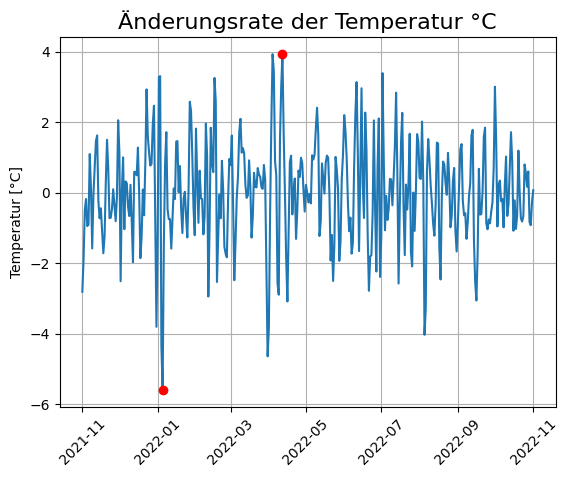

In [82]:
# Liste mit Datumsangaben
val = avg_temperatur
daten = datum

# Berechnung der Ableitung mit np.gradient
ableitung = np.gradient(val)

# Suche nach dem Tag mit der grössten Änderungsrate
max_ableitung = np.max(ableitung)
max_ableitung_tag = daten[np.argmax(ableitung)]
min_ableitung_tag = daten[np.argmin(ableitung)]

# Ausgabe
print(
    "Am Tag",
    max_ableitung_tag.strftime("%d.%m.%Y"),
    "hatten wir die höchste Änderungsrate der Temperatur. \nAm Tag",
    min_ableitung_tag.strftime("%d.%m.%Y"),
    "hatten wir die niedrigste  Änderungsrate der Temperatur.",
)

# Visualisierung
plt.plot(daten, ableitung)
plt.plot(max_ableitung_tag, max_ableitung, "ro")
plt.plot(min_ableitung_tag, np.min(ableitung), "ro")
plt.ylabel("Temperatur [°C]")
plt.title("Änderungsrate der Temperatur °C",size = 16)
plt.xticks(rotation=45)
plt.grid()
plt.show()

Am Tag 26.04.2022 hatten wir die höchste Änderungsrate des Sonnenscheins. 
Am Tag 26.06.2022 hatten wir die niedrigste  Änderungsrate des Sonnenscheins.


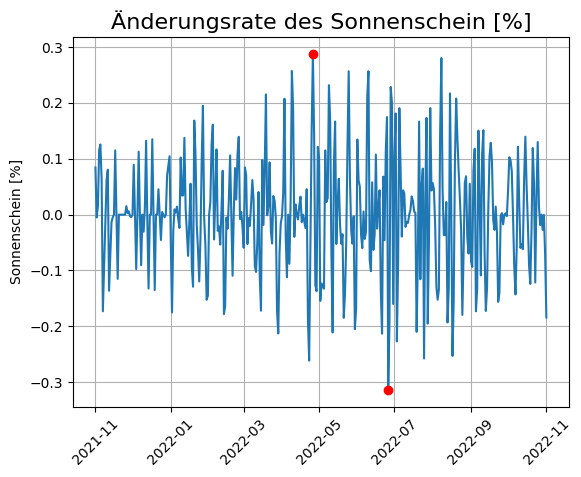

In [83]:
# Liste mit Datumsangaben
val = avg_sonne
daten = datum

# Berechnung der Ableitung mit np.gradient
ableitung = np.gradient(val)

# Suche nach dem Tag mit der grössten Änderungsrate
max_ableitung = np.max(ableitung)
max_ableitung_tag = daten[np.argmax(ableitung)]
min_ableitung_tag = daten[np.argmin(ableitung)]

# Ausgabe
print(
    "Am Tag",
    max_ableitung_tag.strftime("%d.%m.%Y"),
    "hatten wir die höchste Änderungsrate des Sonnenscheins. \nAm Tag",
    min_ableitung_tag.strftime("%d.%m.%Y"),
    "hatten wir die niedrigste  Änderungsrate des Sonnenscheins.",
)

# Visualisierung
plt.plot(daten, ableitung)
plt.plot(max_ableitung_tag, max_ableitung, "ro")
plt.plot(min_ableitung_tag, np.min(ableitung), "ro")
plt.ylabel("Sonnenschein [%]")
plt.title("Änderungsrate des Sonnenschein [%]", size = 16)
plt.xticks(rotation=45)
plt.grid()
plt.show()

Am 14.09.2022 hatten wir die höchste Änderungsrate der Regenmenge. 
Am 16.09.2022 hatten wir die niedrigste Änderungsrate der Regenmenge.


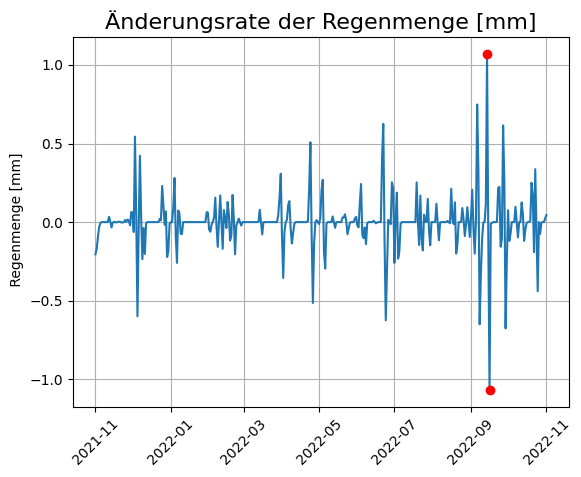

In [84]:
# Liste mit Datumsangaben
val = avg_regen
daten = datum

# Berechnung der Ableitung mit np.gradient
ableitung = np.gradient(val)

# Suche nach dem Tag mit der grössten Änderungsrate
max_ableitung = np.max(ableitung)
max_ableitung_tag = daten[np.argmax(ableitung)]
min_ableitung_tag = daten[np.argmin(ableitung)]

# Ausgabe
print(
    "Am",
    max_ableitung_tag.strftime("%d.%m.%Y"),
    "hatten wir die höchste Änderungsrate der Regenmenge. \nAm",
    min_ableitung_tag.strftime("%d.%m.%Y"),
    "hatten wir die niedrigste Änderungsrate der Regenmenge.",
)

# Visualisierung
plt.plot(daten, ableitung)
plt.plot(max_ableitung_tag, max_ableitung, "ro")
plt.plot(min_ableitung_tag, np.min(ableitung), "ro")
plt.ylabel(" Regenmenge [mm]")
plt.title("Änderungsrate der Regenmenge [mm]", size=16)
plt.xticks(rotation=45)
plt.grid()
plt.show()

## 7. Durch Integration gewisse Durchschnittswerte über einen Zeitraum berechnen

Für den von uns gewählten, betrachteten Frühlingszeitraum vom 20.03.2022 - 21.06.2022 haben wir die Durchschnittswerte von Temperatur, Luftdruck, Regenmenge und Sonnenscheindauer ermittelt.

In [85]:
# Filtern der Daten über den Frühling
filt_datum, filt_temp = zeitraum_filtern(avg_temperatur, datum, '2022-03-20', '2022-06-21')
filt_datum, filt_luftdruck = zeitraum_filtern(avg_luftdruck, datum, '2022-03-20', '2022-06-21')
filt_datum, filt_regen = zeitraum_filtern(avg_regen, datum, '2022-03-20', '2022-06-21')
filt_datum, filt_sonne = zeitraum_filtern(avg_sonne, datum, '2022-03-20', '2022-06-21')

In [86]:
def integration_value(dates, values):
    """
    Berechnet den durchschnittlichen Wert über einen gegebenen Zeitraum basierend auf den übergebenen Datumswerten und
    zugehörigen Werten.

    Args:
        dates (list): Eine Liste von Datumswerten.
        values (list): Eine Liste von Werten, die den Datumswerten entsprechen.

    Returns:
        str: Ausgabe des durchschnittlichen Werts über den gegebenen Zeitraum.
    """
    # Umwandlung der Datumsangaben in Gleitkommazahlen (in Tagen seit dem ersten Datum)
    x = np.array([(d - dates[0]).total_seconds() / 86400 for d in dates])

    # Berechnung des Integrals über den gesamten Zeitraum
    integral_value, _ = quad(lambda t: np.interp(t, x, values), x[0], x[-1])

    # Berechnung des durchschnittlichen Temperaturwerts
    time_span = (dates[-1] - dates[0]).days
    avg_value = integral_value / time_span
    result = print(f'Der durchschnittliche Wert beträgt {avg_value}')
    return result

In [87]:
integration_value(filt_datum,filt_temp)

Der durchschnittliche Wert beträgt 13.444735957975114


C:\Users\chaen\AppData\Local\Temp\ipykernel_30772\724649148.py:17: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral_value, _ = quad(lambda t: np.interp(t, x, values), x[0], x[-1])


In [88]:
def integration_plot(dates, values):
    """
    Berechnet das Integral und den durchschnittlichen Wert für die übergebenen Daten.

    Args:
        dates (list): Eine Liste von Datumswerten.
        values (list): Eine Liste von Werten, die den entsprechenden Datumswerten entsprechen.

    Returns:
        float: Der durchschnittliche Wert über den gegebenen Zeitraum.
    """

    # Umwandlung der Datumsangaben in Gleitkommazahlen (in Tagen seit dem ersten Datum)
    x = np.array([(d - dates[0]).total_seconds() / 86400 for d in dates])

    # Berechnung des Integrals über den gesamten Zeitraum
    integral_value, _ = quad(lambda t: np.interp(t, x, values), x[0], x[-1])

    # Berechnung des durchschnittlichen Temperaturwerts
    time_span = (dates[-1] - dates[0]).days
    avg_val = integral_value / time_span

    return avg_val

C:\Users\chaen\AppData\Local\Temp\ipykernel_30772\1633401530.py:17: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral_value, _ = quad(lambda t: np.interp(t, x, values), x[0], x[-1])


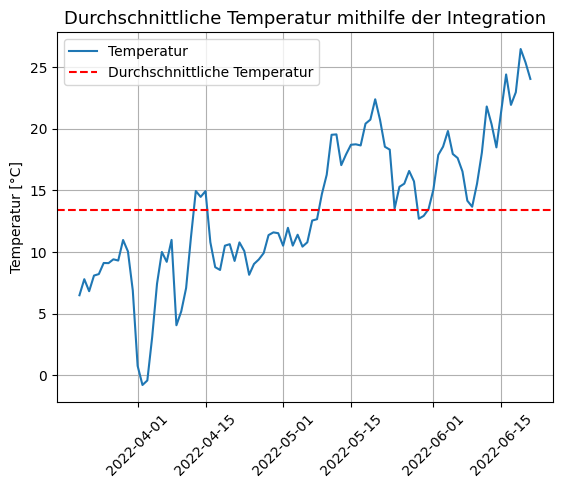

In [89]:
# Daten definieren
dates = filt_datum # Liste der Datumsangaben
values = filt_temp # Liste der Temperaturwerte

# Durchschnittliche Temperatur berechnen
avg_temp = integration_plot(dates,values)

# Plot erstellen
plt.plot(dates, values, label='Temperatur')
plt.axhline(y=avg_temp, color='r', linestyle='--', label='Durchschnittliche Temperatur')
plt.ylabel('Temperatur [°C]')
plt.xticks(rotation=45)
plt.title("Durchschnittliche Temperatur mithilfe der Integration", size = 13)
plt.grid()
plt.legend()
plt.show()


Um das Ganze abzurunden packen wir die Integration in eine Funktion, welche die Datenwerte nimmt und diese in einem Graphen plottet.

In [90]:
def avg_val_integration(dates, values, y_name):
    """
    Berechnet die durchschnittliche Temperatur basierend auf einer Liste von Datumsangaben und zugehörigen Werten.
    Erzeugt ausserdem einen Plot der Daten und markiert den durchschnittlichen Temperaturwert.

    Args:
        dates (list): Eine Liste von Datumswerten.
        values (list): Eine Liste von Werten, die den Datumswerten entsprechen.
        y_name (str): Der Name bzw. die Bezeichnung der Temperaturwerte.

    Returns:
        float: Der durchschnittliche Temperaturwert über den gegebenen Zeitraum.
    """
    
    # Umwandlung der Datumsangaben in Gleitkommazahlen (in Tagen seit dem ersten Datum)
    x = np.array([(d - dates[0]).total_seconds() / 86400 for d in dates])

    # Berechnung des Integrals über den gesamten Zeitraum
    integral_value, _ = quad(lambda t: np.interp(t, x, values), x[0], x[-1])

    # Berechnung des durchschnittlichen Wertes
    time_span = (dates[-1] - dates[0]).days
    avg_val = integral_value / time_span
    print(f'Der durchschnittliche Wert beträgt {avg_val}')

    # Plot erstellen
    plt.plot(dates, values, label=y_name)
    plt.axhline(y=avg_val, color='r', linestyle='--', label=f'Durchschnittlicher {y_name}')
    plt.ylabel(y_name)
    plt.xticks(rotation=45)
    plt.title(f"Durchschnittliche/r {y_name} mithilfe der Integration", size = 13)
    plt.grid()
    plt.legend()
    
    return avg_val

Der durchschnittliche Wert beträgt 952.3988321804188


C:\Users\chaen\AppData\Local\Temp\ipykernel_30772\1648830.py:19: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral_value, _ = quad(lambda t: np.interp(t, x, values), x[0], x[-1])


952.3988321804188

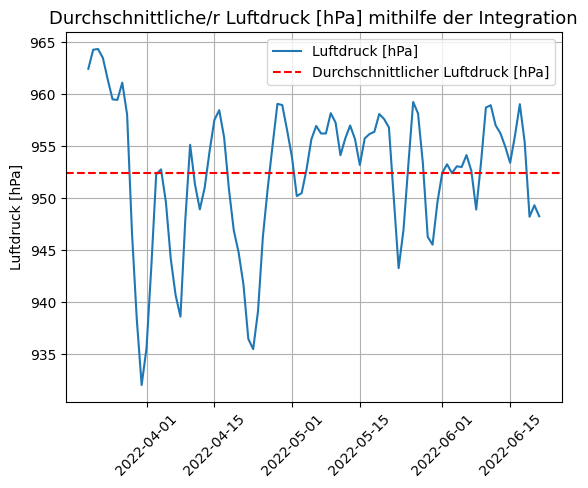

In [91]:
avg_val_integration(filt_datum,filt_luftdruck,'Luftdruck [hPa]')

Der durchschnittliche Wert beträgt 13.444735957975114


C:\Users\chaen\AppData\Local\Temp\ipykernel_30772\1648830.py:19: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral_value, _ = quad(lambda t: np.interp(t, x, values), x[0], x[-1])


13.444735957975114

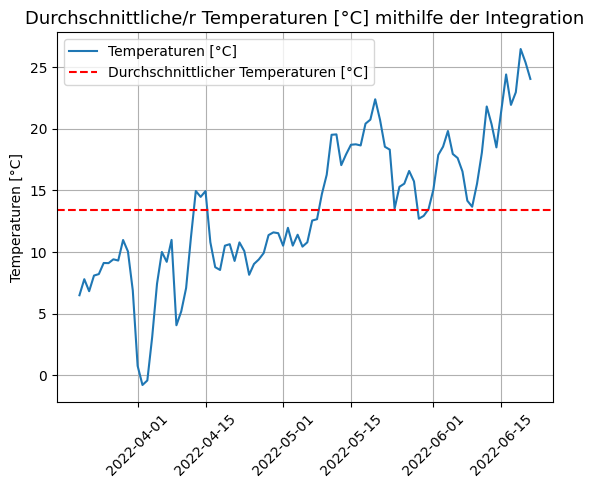

In [92]:
avg_val_integration(filt_datum,filt_temp,'Temperaturen [°C]')

C:\Users\chaen\AppData\Local\Temp\ipykernel_30772\1648830.py:19: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral_value, _ = quad(lambda t: np.interp(t, x, values), x[0], x[-1])


Der durchschnittliche Wert beträgt 0.06924058403776154


0.06924058403776154

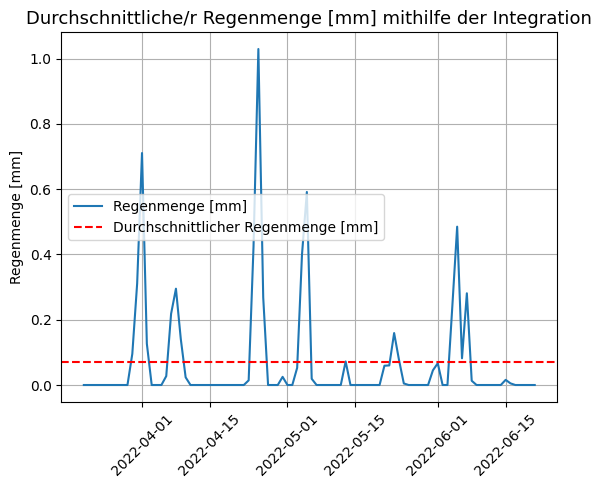

In [93]:
avg_val_integration(filt_datum,filt_regen,'Regenmenge [mm]')

Der durchschnittliche Wert beträgt 0.3471425139412523


C:\Users\chaen\AppData\Local\Temp\ipykernel_30772\1648830.py:19: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral_value, _ = quad(lambda t: np.interp(t, x, values), x[0], x[-1])


0.3471425139412523

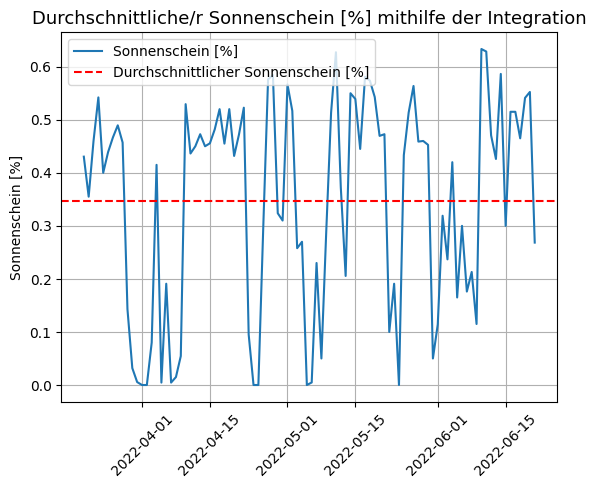

In [94]:
avg_val_integration(filt_datum,filt_sonne,'Sonnenschein [%]')

## 8. Wichtigste Erkenntnisse über die Arbeit 

Während dieser umfassenden Datenanalyse wurden verschiedene Techniken zur Wetterdatenanalyse und -interpretation verwendet.

Um ausführliche Informationen über Temperatur, Luftdruck, Regenmenge und Sonnenscheindauer zu erhalten, haben wir die zur Verfügung gestellten Wetterdaten erstmals extrahiert und verarbeitet. Anschliessend haben wir diese Daten in eine strukturierte Form übertragen, die für die weitere Verarbeitung geeignet ist.

Weiter haben wir, um die Verteilungen und Trends zu visualisieren, Plots erstellt. Diese Visualisierungen halfen, Muster in den Daten zu erkennen, wie beispielsweise den Jahreszyklus der Temperaturänderungen.

Um eine kontinuierlichere Darstellung der Wetterparameter zu erreichen, haben wir Lücken in den Daten durch die Interpolation gefüllt. Hier haben wir vor allem zwei Interpolations-Methoden kennengelernt und konnten diese ausführlich vergleichen. Es handelt sich hierbei um die cubic- und next-Methode.

In einem nächsten Schritt haben wir in den Daten Nullstellen und Schwellenwerte ausfindig gemacht, um Überschreitungen bestimmter Wetterparameter zu finden. Im Winter haben wir zum Beispiel festgestellt, dass der Temperaturschwellenwert von Null Grad Celsius am häufigsten überschritten wurde.

Durch die Ableitung haben wir grosse Änderungen in den Daten finden können. Es gab Tage mit den höchsten und niedrigsten Änderungsraten für verschiedene Wetterparameter welche wir auch visuell darstellten. Dies hat uns unter anderem auch die Möglichkeit gegeben, bedeutende Ereignisse und plötzliche Wetteränderungen zu identifizieren.

Die Integration ermöglichte uns die Berechnung der durchschnittlichen Werte für die verschiedenen Wetterparameter. Dies bot uns eine Methode zur Erfassung repräsentativer Werte für verschiedene meteorologische Ereignisse. Wir haben uns in diesem Fall auf den Frühling beschränkt.

Zusammenfassend ermöglichtde uns diese Art der Analyse ein tiefes Verständnis der Wetterdaten. Wir konnten spezifische Ereignisse wie zum Beispiel die erwartungsgemässen Wetterbedingungen in den verschiedenen Jahreszeiten identifiziert sowie auch spezifische Ereignisse wie zum Beispiel "Wann ist der Luftdruck unter 940 hPa gefallen" analysieren. Zudem konnten so auch generelle Trends visuell dargestellt werden. Wir haben gelernt, komplexe Muster in den Daten durch die Verwendung von Techniken wie Visualisierung, Interpolation, Schwellenwertanalyse, Ableitung und Integration zu handhaben. In der Zukunft bietet dies eine Grundlage für zukünftige Forschungsprojekte und könnte in Bereichen wie Klima- und Wetterstudien von Vorteil sein.

## 9. Reflektion der Gruppenarbeit


Unsere Gruppenarbeit zeichnete sich durch eine effektive Aufgabenteilung und Zusammenarbeit aus. Jedes Teammitglied hatte eigene Zuständigkeiten, die zu einem reibungslosen Arbeitsablauf beitrugen. Iris war hauptsächlich für den Import der Daten und das Filtern zuständig. Sie verfügte über das notwendige Wissen, um die fehlenden Daten zu identifizieren und diese zu filtern. Zusätzlich übernahm sie die Organisation der Gruppenarbeit, was die Erstellung der Präsentation und das Führen des Journals umfasste. Diese Organisation war von unschätzbarem Wert und trug dazu bei, dass wir den Überblick behielten und effektiv arbeiten konnten. Chantal und Riccardo arbeiteten an den restlichen Aufgaben. Chantal trug wesentlich zur Programmierung und Implementierung des Projekts bei. Riccardo wiederum spielte eine entscheidende Rolle bei der Entwicklung des Codes. Seine Beiträge waren geprägt von wichtigen Erkenntnissen, die er in den Code integrierte, um eine optimale Funktionalität sicherzustellen. 

Zusätzlich zu den individuellen Zuständigkeiten haben wir alle gemeinsam an der Reflektion der Arbeit mitgewirkt. Wir haben regelmässige Treffen abgehalten, um den Fortschritt zu besprechen und potenzielle Probleme frühzeitig anzugehen. Dabei haben wir das Journal genutzt, um unsere Ziele festzulegen, die nächsten Schritte zu planen und wichtige Erkenntnisse zu dokumentieren. Dieses Journal war ein wertvolles Instrument, das dazu beitrug, dass wir unseren Zeitplan einhalten und effektiv zusammenarbeiten konnten. Es diente auch als Referenzpunkt für unseren Zeitplan. Wir konnten die Fortschritte dokumentieren, den Arbeitsaufwand einschätzen und den Projektzeitplan aktualisieren. Es half uns, den Überblick über unsere Arbeit zu behalten und sicherzustellen, dass wir die geplanten Meilensteine rechtzeitig erreichten.

Die regelmässigen Treffen und Besprechungen ermöglichten uns, eventuelle Probleme oder Herausforderungen frühzeitig zu erkennen und gemeinsam Lösungen zu finden. Dadurch konnten wir Engpässe vermeiden und die Effizienz unserer Arbeitsabläufe gewährleisten. Insgesamt hat die ständige Kommunikation im Team massgeblich dazu beigetragen, dass wir unsere Ziele einhalten konnten. Wir waren alle zu Beginn der Arbeit etwas unsicher, da wir uns zunächst über das genaue Verständnis der geforderten Aufgaben klarwerden mussten. Dies führte dazu, dass wir zu Beginn viel Code geschrieben haben, der verworfen werden musste. Es war frustrierend, aber es war ein notwendiger Schritt, um das Wissen für die
Umsetzung zu erarbeiten und die Aufgabenstellungen richtig zu verstehen. Sobald wir dieses Verständnis erreicht hatten, konnten wir richtig loslegen und mit dem Programmieren beginnen.

In Bezug auf die Zusammenarbeit hatten wir das Glück, eine wirklich gute Gruppe getroffen zu haben. Wir waren alle motiviert und zogen an einem Strang. Niemand musste gefragt werden, etwas zu tun, da jeder individuell an der Arbeit weitergearbeitet hat. Die Kommunikation war schnell und effektiv, und jeder hat immer zeitnah auf Nachrichten geantwortet. Das hat dazu geführt, dass wir uns gegenseitig unterstützen und motivieren konnten. Es war klar, dass jedem Teammitglied die Arbeit wichtig war und dass wir alle das gleiche Ziel hatten.

Ursprünglich hatten wir uns auf eine bestimmte Rollenverteilung geeinigt, bei der wir die Aufgaben auf Personen und pro Woche aufgeteilt haben. Im Laufe der Arbeit haben wir jedoch unseren eigenen Rhythmus gefunden und konnten gemeinsam voranschreiten. Jeder hat seinen Teil programmiert, überarbeitet und dokumentiert. Es gab eine gute Balance zwischen individuellen Beiträgen und Zusammenarbeit. In Bezug auf die Einschätzung der individuellen Beiträge sind wir der Meinung, dass die Arbeit ziemlich gleichmässig aufgeteilt wurde. Diese Aufgabenaufteilung ergab sich spontan und war das Ergebnis von Ressourcen, Kenntnissen und persönlichen Stärken jedes Teammitglieds.

Insgesamt sind wir mit unserer Gruppenarbeit sehr zufrieden. Trotz anfänglicher Schwierigkeiten waren wir stets motiviert und konnten so den roten Faden finden. Jeder hat einen Beitrag geleistet und wir sind stolz auf das Ergebnis, das wir als Team erreicht haben. Diese Erfahrung hat uns gezeigt, wie wichtig klare Kommunikation, gegenseitige Unterstützung und Flexibilität in einer Gruppenarbeit sind. 